In [2]:
# --- Imports ---
%matplotlib inline

import geopandas as gpd
import math
import matplotlib
import numpy as np
import pandas as pd
import shapely
import sys,os
import multiprocessing
from geopandas import GeoDataFrame, GeoSeries
from shapely.geometry import Polygon, Point
from rtree import index



## Load and clean constraint shapefiles

In [7]:
cities = GeoDataFrame.from_file('./geodata/ca_cities/Cities2015.shp')
water = GeoDataFrame.from_file('./geodata/baywater/bayarea_allwater.shp')

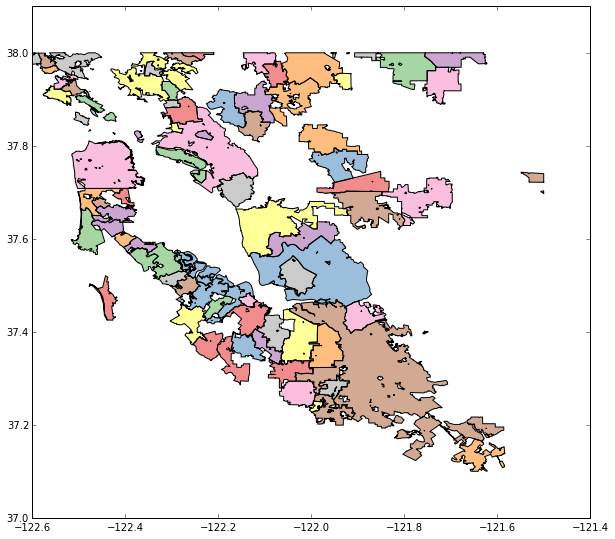

In [8]:

# This is the cropped area - full geojson is all cities in CA
bayarea = Polygon([(-122.6, 37.1), (-121.5,37.1), (-121.5,38), (-122.6,38)])
df = GeoDataFrame(geometry=GeoSeries([bayarea]),crs={'init': 'epsg:4269'})

# crop cities
ca_cities = cities.intersection(df.geometry.unary_union)

# convert water to same spatial projection
ca_water = water.to_crs(ca_cities.crs)

# Exclude water bodies using water shapefile
ca_cities_clean = ca_cities.difference(ca_water.geometry.unary_union)
ca_cities_clean.plot(figsize=(10,10))


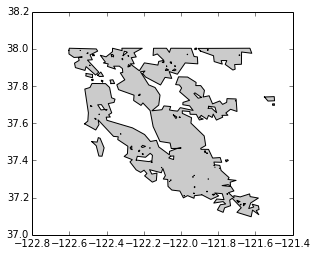

In [9]:

# Generate single geometry shape of target area
simple_ca = GeoDataFrame(geometry=GeoSeries(ca_cities_clean.buffer(0).geometry.unary_union),crs={'init': 'epsg:4269'})

# Buffer and reduce complexity of geometry - covers costal regions + improves performance
simple_ca = simple_ca.buffer(0.003).simplify(0.01, preserve_topology=True)
simple_ca.plot()


## Construct circle covering and transform to target area

In [10]:

# Accumulate initial circle grid
circles = []
for i in range(0, 50):
    for j in range(0, 50):
        circles.append([i,j])


CPU times: user 74.1 ms, sys: 7.8 ms, total: 81.9 ms
Wall time: 509 ms


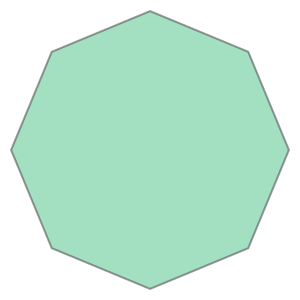

In [11]:

# Function transforming initial grid into hex grid layout
xoffset = 0
yoffset = 0
r = 2000
def create_point(data):
    i = data[0]
    j = data[1]
    p = Point(i*r*math.sqrt(3) + (r*math.sqrt(3)/2 if j%2 else 0) + xoffset,
              j*r*3/4*2+yoffset)
    return shapely.affinity.scale(p.buffer(7).simplify(0.8, preserve_topology=False), xfact=r/7, yfact=r/7)

# Parallel conversion

pool = multiprocessing.Pool(multiprocessing.cpu_count()-1)
%time circles = pool.map(create_point, circles)

# Render the initial circle, demonstrating size and shape
circles[0]


In [12]:

math.sqrt(circles[0].area/math.pi)


1892.9557433318894

In [13]:

# EPSG:2768 ca meters
search_circles = GeoDataFrame(geometry=GeoSeries(circles))
df = GeoDataFrame(geometry=GeoSeries(circles))
df.crs = {'init': 'epsg:2768'}

# Transfrom from meter baed EPSG:2768 coordinate system to lat/long degrees based EPSG:4269
%time df = df.to_crs(ca_cities_clean.crs)


CPU times: user 597 ms, sys: 10.8 ms, total: 607 ms
Wall time: 609 ms


In [14]:
# Translation normalization from offset due to change in coordinate systems
%time df = df.translate(xoff=141.3, yoff=-30, zoff=0.0)

# Translate circle covering to target location
#%time df = df.translate(xoff=-122.2, yoff=37.4, zoff=0.0)
%time df = df.translate(xoff=-122.6, yoff=37, zoff=0.0)


CPU times: user 561 ms, sys: 19.5 ms, total: 581 ms
Wall time: 584 ms
CPU times: user 504 ms, sys: 6.56 ms, total: 511 ms
Wall time: 511 ms


## Load existing spawn data + store in rtree for existing spawn selection

In [15]:
mons = pd.read_csv('./data/pokemon.csv', skiprows=1, usecols=[3,4,5,6], names=["num", "lat", "lng", "time"], low_memory=False)
mons.last_valid_index()

7314094

In [50]:

# Build rtree indexed dataset of existing mon spawns
idx = index.Index()

filtered_mon = mons.query('36<lat<38.1 and -123<lng<-120')
lats = filtered_mon['lat'].as_matrix()
lons = filtered_mon['lng'].as_matrix()
position_stack = np.dstack((lons,lats))

cells = []

# Populate R-tree index with bounds of grid cells
for pos, cell in enumerate(position_stack[0]):
    # assuming cell is a shapely object

    idx.insert(pos, (cell[0], cell[1],cell[0]+0.001, cell[1]+0.001))

filtered_mon.shape


(227413, 4)

## Filter circle query points to intersections with geometric set

CPU times: user 195 ms, sys: 31.1 ms, total: 226 ms
Wall time: 1.39 s


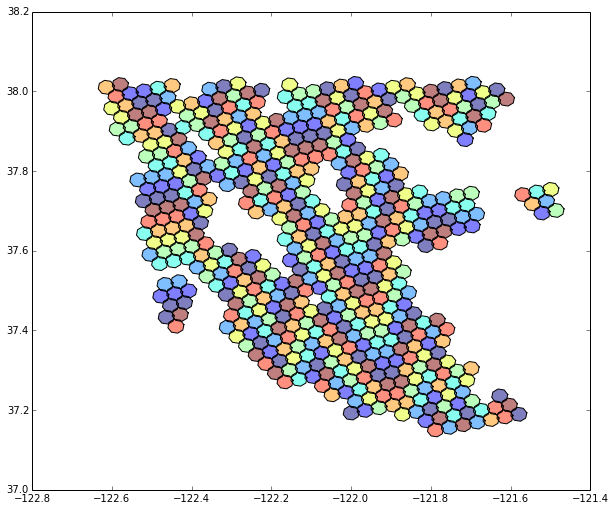

In [49]:

# Filter all circles to intersection with the target geometry
simple_ca_union = simple_ca.buffer(0).geometry.unary_union

def filter_circles_not_inside(data):
    if simple_ca_union.intersects(data):
        return data
    else:
        return False

final_circles = []
pool = multiprocessing.Pool(multiprocessing.cpu_count()-1)
%time final_circles = filter(lambda x: x != False, pool.map(filter_circles_not_inside, df.geometry))

search_circles = GeoDataFrame(geometry=GeoSeries(final_circles))
search_circles.plot(figsize=(10,10))

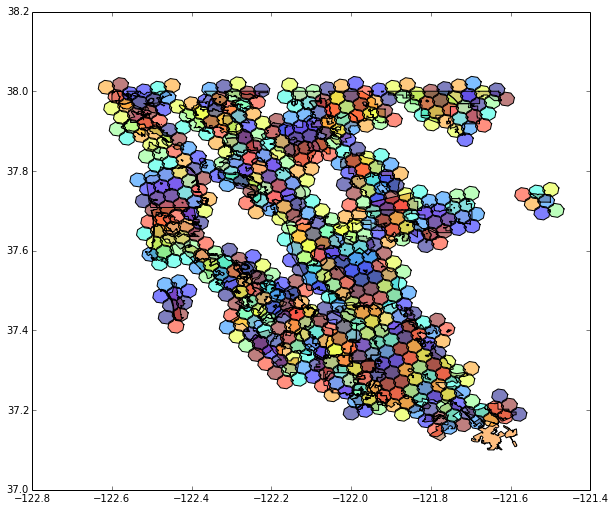

In [14]:
search_circles.plot(ax=ca_cities_clean.plot(figsize=(10,10)), figsize=(10,10))

## Coverage based solely on existing spawn points

CPU times: user 170 ms, sys: 25.9 ms, total: 196 ms
Wall time: 258 ms


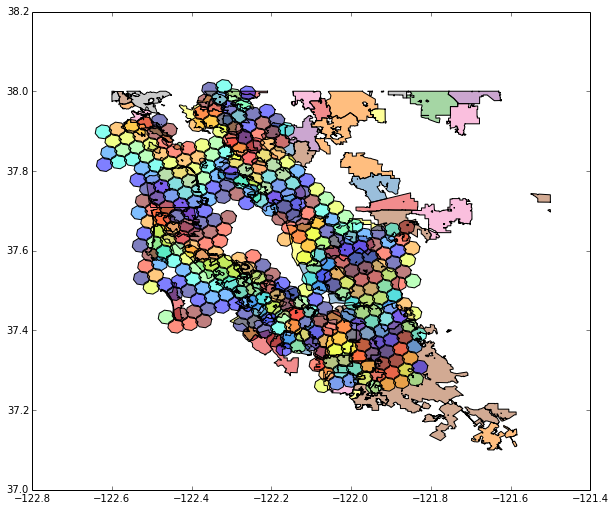

In [51]:

# Filter all circles to intersection with the target geometry

def filter_circles_not_inside(data):
    if len(list(idx.intersection(data.bounds))):
        return data
    else:
        return False

final_circles = []
pool = multiprocessing.Pool(multiprocessing.cpu_count()-1)
%time final_circles = filter(lambda x: x != False, pool.map(filter_circles_not_inside, df.geometry))

search_circles = GeoDataFrame(geometry=GeoSeries(final_circles))
search_circles.plot(ax=ca_cities_clean.plot(figsize=(10,10)), figsize=(10,10))